## Time Series regression - Long short-term memory (LSTM)

In [1]:
# DAL Library
# version 1.0.50

source("https://raw.githubusercontent.com/cefet-rj-dal/dal/main/examples/jupyter_daltoolbox.R")

#loading DAL
load_daltoolbox()
loadlibrary("reticulate")
source("https://raw.githubusercontent.com/cefet-rj-dal/dal/main/examples/ts_tlstm.R")
reticulate::source_python("https://raw.githubusercontent.com/cefet-rj-dal/dal/main/examples/ts_tlstm.py")

Loading required package: daltoolbox

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
“replacing previous import ‘dplyr::filter’ by ‘stats::filter’ when loading ‘daltoolbox’”

Attaching package: ‘daltoolbox’


The following objects are masked from ‘package:base’:

    jitter, transform


Loading required package: reticulate



### Cosine series for studying

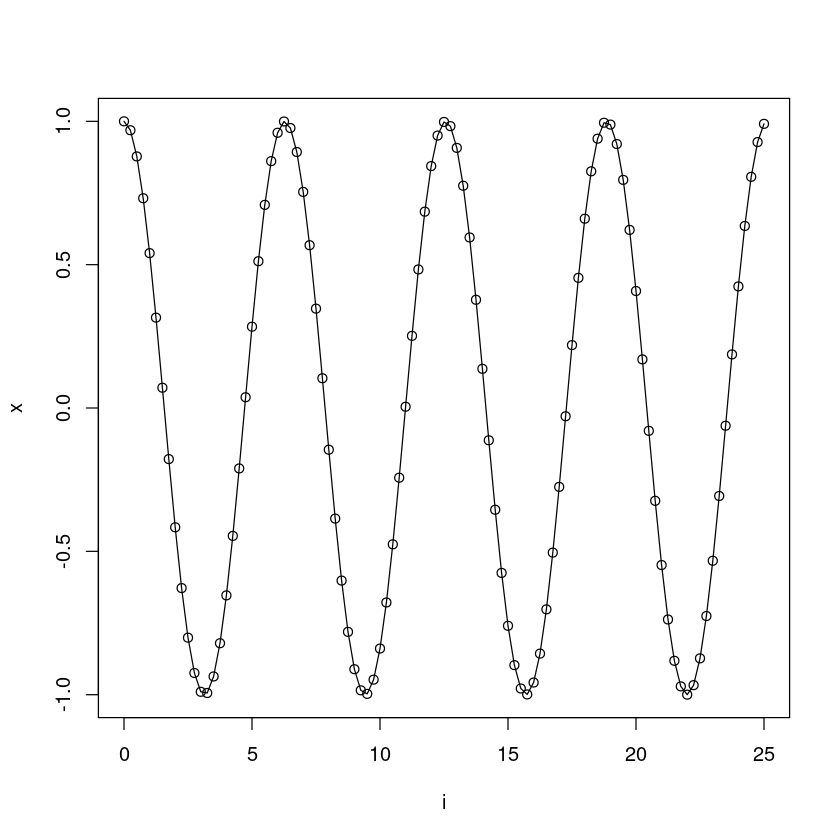

In [2]:
i <- seq(0, 25, 0.25)
x <- cos(i)

plot(i, x)
lines(i, x)

### sliding windows

In [3]:
sw_size <- 10
ts <- ts_data(x, sw_size)
tshead(ts, 3)

t9,t8,t7,t6,t5,t4,t3,t2,t1,t0
1.0000000,0.9689124,0.8775826,0.7316889,0.5403023,0.3153224,0.0707372,-0.1782461,-0.4161468,-0.6281736
0.9689124,0.8775826,0.7316889,0.5403023,0.3153224,0.0707372,-0.1782461,-0.4161468,-0.6281736,-0.8011436
0.8775826,0.7316889,0.5403023,0.3153224,0.0707372,-0.1782461,-0.4161468,-0.6281736,-0.8011436,-0.9243024


### data sampling

In [4]:
test_size <- 1
samp <- ts_sample(ts, test_size)
tshead(samp$train, 3)
tshead(samp$test)

t9,t8,t7,t6,t5,t4,t3,t2,t1,t0
1.0000000,0.9689124,0.8775826,0.7316889,0.5403023,0.3153224,0.0707372,-0.1782461,-0.4161468,-0.6281736
0.9689124,0.8775826,0.7316889,0.5403023,0.3153224,0.0707372,-0.1782461,-0.4161468,-0.6281736,-0.8011436
0.8775826,0.7316889,0.5403023,0.3153224,0.0707372,-0.1782461,-0.4161468,-0.6281736,-0.8011436,-0.9243024


t9,t8,t7,t6,t5,t4,t3,t2,t1,t0
-0.7256268,-0.532833,-0.3069103,-0.06190529,0.1869486,0.424179,0.635036,0.8064095,0.9276444,0.9912028


### data preprocessing

In [5]:
preproc <- ts_gminmax()

### Model training

In [6]:
model <- ts_tlstm(preproc, input_size=4, epochs=10000)

io_train <- ts_projection(samp$train)
model <- fit(model, x=io_train$input, y=io_train$output)

print(describe(model))

ts_tlstm,0.024



[1] "ts_tlstm"


### Evaluation of adjustment

In [7]:
adjust <- predict(model, io_train$input)
ev_adjust <- evaluation.tsreg(io_train$output, adjust)
print(head(ev_adjust$metrics))

           mse      smape
1 9.741299e-05 0.04511018


### Prediction of test

In [8]:
steps_ahead <- 1
io_test <- ts_projection(samp$test)
prediction <- predict(model, x=io_test$input, steps_ahead=steps_ahead)
prediction <- as.vector(prediction)

output <- as.vector(io_test$output)
if (steps_ahead > 1)
    output <- output[1:steps_ahead]

print(sprintf("%.2f, %.2f", output, prediction))

[1] "0.99, 0.98"


### Evaluation of test data

In [9]:
ev_test <- evaluation.tsreg(output, prediction)
print(head(ev_test$metrics))
print(sprintf("%s: smape: %.2f", describe(model), 100*ev_test$metrics$smape))

           mse      smape
1 0.0001074969 0.01051509
[1] "ts_tlstm: smape: 1.05"


### Plot results

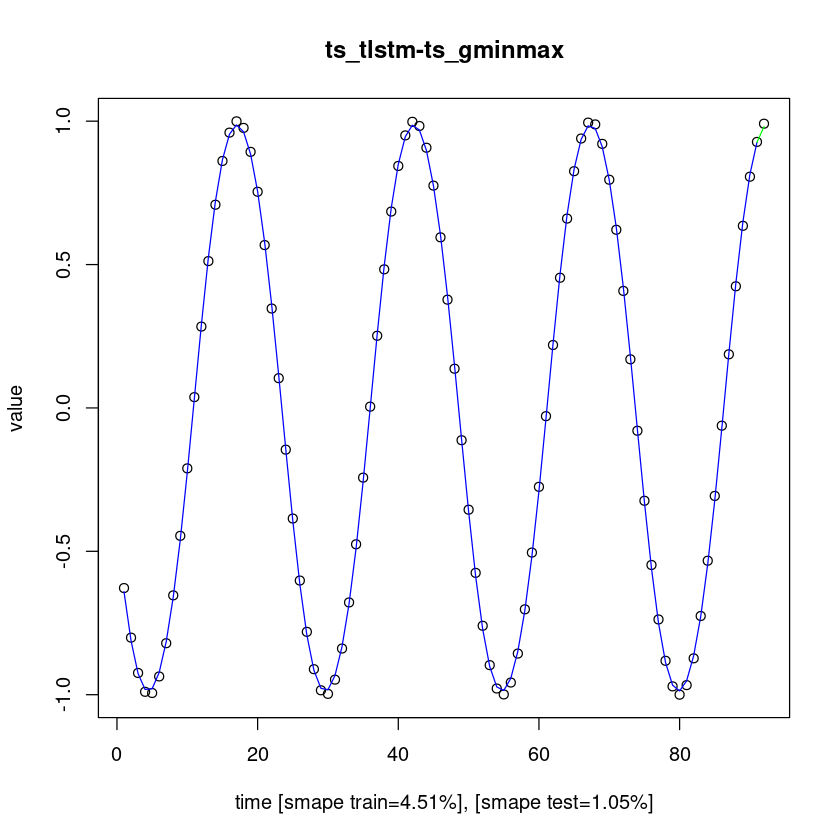

In [10]:
yvalues <- c(io_train$output, io_test$output)
tsplot(model, y=yvalues, yadj=adjust, ypre=prediction)